In [ ]:
%matplotlib inline
import lightkurve as lk
import numpy as np
import pandas as pd
import os
from pathlib import Path
import tensorflow as tf
import astropy

pd.options.display.max_colwidth = 10000

# tpf = lk.read("../../dataset/fits/757450.fits")
# # tpf.plot(frame=100, scale='log', show_colorbar=True)

# lc = tpf.to_lightcurve(aperture_mask = tpf.pipeline_mask)
# flat_lc = lc.flatten()

# flux = flat_lc.flux

# nuFlux = []

# for x in range(len(flux)):
#     print(flux[x])
#     nuFlux.append(float(flux[x]))

# print(nuFlux)

cols = ["kepid","fluxSequence","disposition"]
fluxSet = pd.DataFrame(columns=cols)




fits = pd.read_csv("../../dataset/fits.csv", index_col="id")
fits.head()

for index, row in fits.iterrows():
    kepid = row["kepid"]
    disposition = row["koi_disposition"]

    tpf = lk.read("../../dataset/fits/" + str(kepid) + ".fits")
    lc = tpf.to_lightcurve(aperture_mask = tpf.pipeline_mask)
    flat_lc = lc.flatten()

    flux = flat_lc.flux

    nuFlux = []

    for x in range(len(flux)):
        nuFlux.append(float(flux[x]))


    fluxSet.loc[len(fluxSet)] = [kepid,nuFlux,disposition]
    print(index)

# fluxSet.head()
fluxSet.to_json("fluxSet.json")





In [ ]:
%matplotlib inline
import lightkurve as lk
import numpy as np
import pandas as pd
import os
from pathlib import Path
from keras._tf_keras.keras.utils import pad_sequences
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix
import astropy

# from tensorflow.python import keras
# from keras import *

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM

flux = pd.read_json("../../dataset/fluxSet.json")
flux.tail()

flux = flux.sample(frac=1).reset_index(drop=True)

flux.head(10)

label_map = {
    'FALSE POSITIVE': 0,
    'CONFIRMED': 1
}

sequences = flux['fluxSequence'].tolist()
labels = flux['disposition'].map(label_map).astype('float32').values

print(sequences[0])
print(labels[0])

max_len = max(len(seq) for seq in sequences)
print(max_len)

padded_sequences = pad_sequences(sequences, padding="post",dtype="float32")
print(len(padded_sequences))

x = np.expand_dims(padded_sequences, axis = 1)
y = np.array(labels)

print(x.shape)

X_train, X_val, y_train, y_val = train_test_split(x, y, test_size=0.2)

model = Sequential()
model.add(Input(shape=(x.shape[1], x.shape[2])))
model.add(LSTM(64))
model.add(Dropout(0.5))
model.add(Dense(1, activation= "sigmoid"))

print(model)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10, batch_size=1, validation_data=(X_val, y_val))

In [12]:
from astroquery.nasa_exoplanet_archive import NasaExoplanetArchive
import pandas as pd

# Step 1: Query CONFIRMED KOIs
confirmed = NasaExoplanetArchive.query_criteria(
    table="q1_q17_dr25_koi",
    select="kepid, koi_disposition",  # Only kepid and koi_disposition
    where="koi_disposition = 'CONFIRMED'"
).to_pandas().dropna()

# Step 2: Query FALSE POSITIVE KOIs
false_positives = NasaExoplanetArchive.query_criteria(
    table="q1_q17_dr25_koi",
    select="kepid, koi_disposition",  # Only kepid and koi_disposition
    where="koi_disposition = 'FALSE POSITIVE'"
).to_pandas().dropna()

# Step 3: Keep only one KOI per star (shortest period)
confirmed_unique = confirmed.sort_values("koi_disposition").drop_duplicates(subset="kepid", keep="first")
false_unique = false_positives.sort_values("koi_disposition").drop_duplicates(subset="kepid", keep="first")

# Step 4: Remove overlapping kepids (same star in both groups)
overlap_kepids = set(confirmed_unique['kepid']).intersection(set(false_unique['kepid']))
# print(f"Number of overlapping kepids: {len(overlap_kepids)}")

confirmed_clean = confirmed_unique[~confirmed_unique['kepid'].isin(overlap_kepids)]
false_clean = false_unique[~false_unique['kepid'].isin(overlap_kepids)]

# Step 5: Sample 1000 unique stars from each class
confirmed_sample = confirmed_clean.sample(n=50, random_state=42)
false_sample = false_clean.sample(n=50, random_state=42)

# Step 6: Combine and shuffle
balanced_df = pd.concat([confirmed_sample, false_sample], ignore_index=True)
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Step 7: Save to CSV
balanced_df.to_csv("nuSmallSet.csv", index=False)

# Final check
print(f"Final dataset size: {len(balanced_df)} rows")
print(f"Unique stars (kepid): {balanced_df['kepid'].nunique()}")
print(balanced_df.head())

C:\Users\jarvi\AppData\Local\Temp\ipykernel_14936\956351783.py:1: DeprecationWarning: the ``nasa_exoplanet_archive`` module has been moved to astroquery.ipac.nexsci.nasa_exoplanet_archive, please update your imports.
  from astroquery.nasa_exoplanet_archive import NasaExoplanetArchive


Final dataset size: 100 rows
Unique stars (kepid): 100
      kepid koi_disposition
0   7418173  FALSE POSITIVE
1   7375795  FALSE POSITIVE
2   9665922  FALSE POSITIVE
3  10854546       CONFIRMED
4  11963206       CONFIRMED


Number of light curves found for kepid 6665695: 5
18399


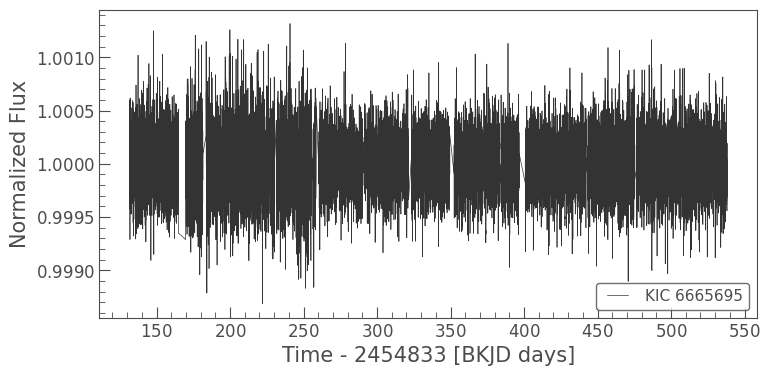

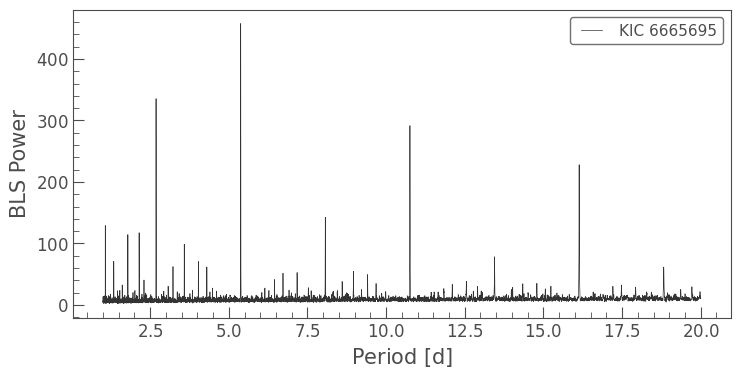

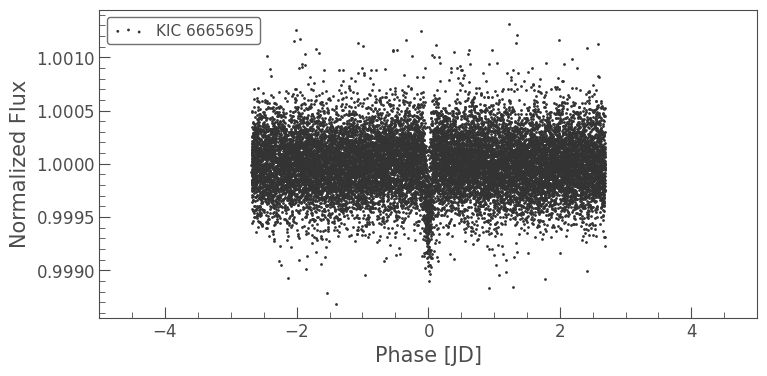

In [118]:
import lightkurve as lk
import numpy as np

# Define the kepid for which you want to retrieve data (e.g., kepid = 123456789)
kepid = 6665695

kepid_corrected = f"KIC{kepid}"

# Step 1: Search for all available light curves for this kepid
search_result = lk.search_lightcurve(kepid_corrected, limit = 5)

# Step 2: Check how many light curves were returned
print(f"Number of light curves found for kepid {kepid}: {len(search_result)}")

lightcurves = search_result.download_all()

combined_lightcurve = lightcurves.stitch().flatten().remove_outliers()

combined_lightcurve.plot()

period = np.linspace(1, 20, 10000)
# Create a BLSPeriodogram
bls = combined_lightcurve.to_periodogram(method='bls', period=period, frequency_factor=500)
bls.plot()

planet_b_period = bls.period_at_max_power
planet_b_t0 = bls.transit_time_at_max_power
planet_b_dur = bls.duration_at_max_power

ax = combined_lightcurve.fold(period=planet_b_period, epoch_time=planet_b_t0).scatter()
radius = 5
ax.set_xlim(-radius, radius)

print(len(combined_lightcurve.flux))

In [ ]:
import pandas as pd
import lightkurve as lk
import os
import concurrent.futures

# === 1. Load your dataset ===
# This assumes your CSV has 'kepid' and 'koi_disposition' columns
df = pd.read_csv("nuSet.csv")  # update with your path
kepids = df["kepid"].unique().tolist()

# === 2. Define where to save light curves ===
save_dir = "lightcurves_fits"
os.makedirs(save_dir, exist_ok=True)

# === 3. Define the download & save function ===
def download_and_save_lightcurve(kepid):
    try:
        # Define path
        filepath = os.path.join(save_dir, f"KIC{kepid}.fits")
        
        # Skip if already exists
        if os.path.exists(filepath):
            return f"Skipped {kepid} (already exists)"

        # Download stitched light curve
        search_result = lk.search_lightcurve(f"KIC{kepid}", limit = 5)
        lc = search_result.download_all().stitch()
        
        # Save as FITS
        lc.to_fits(filepath)
        return f"Downloaded {kepid}"
    
    except Exception as e:
        return f"Error with {kepid}: {e}"

# === 4. Download in parallel using threading ===
results = []
with concurrent.futures.ThreadPoolExecutor(max_workers=6) as executor:
    futures = [executor.submit(download_and_save_lightcurve, kepid) for kepid in kepids]
    for future in concurrent.futures.as_completed(futures):
        results.append(future.result())
        print(results[-1])  # Print progress

# === 5. Optional: Save the log to a file ===
with open("download_log.txt", "w") as f:
    for line in results:
        f.write(f"{line}\n")


Error with 8127639: I/O operation on closed file.
Downloaded 9640931


 [Done]


 [Done]


In [16]:
import pandas as pd
import lightkurve as lk
import os
import concurrent.futures
import warnings
from threading import Lock
from astropy.utils.exceptions import AstropyWarning

# === Suppress astropy unit warnings ===
warnings.simplefilter('ignore', category=AstropyWarning)

# === Load the dataset of KOIs ===
df = pd.read_csv("nuSmallSet.csv")  # Make sure this matches your file
kepids = df["kepid"].unique().tolist()

# === Directory to save light curves ===
save_dir = "lightcurves_fits"
os.makedirs(save_dir, exist_ok=True)

# === Create a lock for thread-safe file saving ===
save_lock = Lock()

# === Function to download and save light curve ===
def download_and_save_lightcurve(kepid):
    try:
        filepath = os.path.join(save_dir, str(kepid) + ".fits")

        # Skip if file already exists
        if os.path.exists(filepath):
            return f"Skipped {kepid} (already exists)"

        # Search and download light curves
        search_result = lk.search_lightcurve(f"KIC{kepid}", limit = 5, author = "Kepler")
        lc_collection = search_result.download_all()
        print("Downloaded: " + str(kepid))
        if lc_collection is None:
            return f"No data for {kepid}"
        
        stitched_lc = lc_collection.stitch()

        # Save safely using a lock
        with save_lock:
            stitched_lc.to_fits(filepath)

        return f"Downloaded {kepid}"

    except Exception as e:
        return f"Error with {kepid}: {e}"

# # === Multithreaded download ===
# results = []
# with concurrent.futures.ThreadPoolExecutor(max_workers=4) as executor:
#     futures = [executor.submit(download_and_save_lightcurve, kepid) for kepid in kepids]
#     for future in concurrent.futures.as_completed(futures):
#         result = future.result()
#         results.append(result)
#         print(result)

# # === Save download log ===
# with open("download_log.txt", "w") as log_file:
#     for line in results:
#         log_file.write(f"{line}\n")

i = 1
for kepid in kepids:
    download_and_save_lightcurve(kepid)
    print(i)
    i+=1


Downloaded: 7418173
1
Downloaded: 7375795
2
Downloaded: 9665922
3
Downloaded: 10854546
4
Downloaded: 11963206
5
Downloaded: 12256520
6
Downloaded: 3967760
7
Downloaded: 5879448
8
Downloaded: 7364176
9
Downloaded: 8564587
10
Downloaded: 5177859
11
Downloaded: 6851425
12
Downloaded: 5471770
13
Downloaded: 10905746
14
Downloaded: 10186945
15
Downloaded: 6205228
16
Downloaded: 3644523
17
Downloaded: 11250867
18
Downloaded: 8162789
19
Downloaded: 5865654
20
Downloaded: 7812893
21
Downloaded: 3656322
22
Downloaded: 8142942
23
Downloaded: 8591173
24
Downloaded: 12121470
25
Downloaded: 6124512
26
Downloaded: 7215603
27
Downloaded: 7177766
28
Downloaded: 10063802
29
Downloaded: 11342573
30
Downloaded: 10005758
31
Downloaded: 3867615
32
Downloaded: 10215422
33
Downloaded: 9006186
34
Downloaded: 5475641
35
Downloaded: 7950644
36
Downloaded: 7811537
37
Downloaded: 2707985
38
Downloaded: 6118370
39
Downloaded: 11135308
40
Downloaded: 9883606
41
Downloaded: 3426367
42
Downloaded: 9034103
43
Download

In [11]:
import pandas as pd
import lightkurve as lk
import os
import concurrent.futures
import warnings
from threading import Lock
from astropy.utils.exceptions import AstropyWarning
from pathlib import Path

# === Suppress astropy unit warnings ===
warnings.simplefilter('ignore', category=AstropyWarning)

# === Load the dataset of KOIs ===
df = pd.read_csv("nuSmallSet.csv")  # Make sure this matches your file
kepids = df["kepid"].unique().tolist()

# === Directory to save light curves ===
save_dir = "lightcurves_fits"
os.makedirs(save_dir, exist_ok=True)

# === Create a lock for thread-safe file saving ===
save_lock = Lock()

# # === Function to download and save light curve ===
# def download_and_save_lightcurve(kepid):
#     try:
#         filepath = os.path.join(save_dir, str(kepid) + ".fits")

#         # Skip if file already exists
#         if os.path.exists(filepath):
#             return f"Skipped {kepid} (already exists)"

#         # Search and download light curves
#         search_result = lk.search_lightcurve(f"KIC{kepid}", limit = 5)
#         lc_collection = search_result.download_all()
#         print("Downloaded: " + str(kepid))
#         if lc_collection is None:
#             return f"No data for {kepid}"
        
#         stitched_lc = lc_collection.stitch()

#         # Save safely using a lock
#         with save_lock:
#             stitched_lc.to_fits(filepath)

#         return f"Downloaded {kepid}"

#     except Exception as e:
#         return f"Error with {kepid}: {e}"



# i = 1
# for kepid in kepids:
#     download_and_save_lightcurve(kepid)
#     print(i)
#     i+=1

strDir = "C:/Users/jarvi/Desktop/exoplanets/python/testing/lightcurves_fits"

directory = os.fsencode(strDir)

setFiles = []
setDf = []

for file in os.listdir(directory):
    filename = os.fsdecode(file)
    setFiles.append(str(Path(filename).stem))

for kepid in kepids:
    setDf.append(str(kepid))

print(list(set(setDf) - set(setFiles)))

['2707985']


In [ ]:
import os
import numpy as np
import pandas as pd
import lightkurve as lk
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

# === CONFIG ===
DATASET_CSV = "nuSmallSet.csv"   # Your kepid/disposition CSV
FITS_DIR = "lightcurves_fits"                  # Directory where your .fits files are stored
MAX_LEN = 2000                                 # Max length for light curve padding

# === STEP 1: LOAD DATASET AND LABELS ===
df = pd.read_csv(DATASET_CSV)
label_map = {"CONFIRMED": 1, "FALSE POSITIVE": 0}

X = []
y = []

def load_lightcurve(filepath):
    try:
        lc = lk.read(filepath)
        lc = lc.normalize().remove_nans().flatten()
        return lc.flux.value
    except Exception as e:
        print(f"Error reading {filepath}: {e}")
        return None

print("Loading light curves...")
for _, row in df.iterrows():
    kepid = row["kepid"]
    label = label_map.get(row["koi_disposition"])
    filepath = os.path.join(FITS_DIR, str(kepid) + ".fits")
    
    if os.path.exists(filepath):
        flux = load_lightcurve(filepath)
        if flux is not None:
            X.append(flux)
            y.append(label)

print(f"Loaded {len(X)} light curves.")

# === STEP 2: PAD SEQUENCES ===
print("Padding sequences...")
X_padded = pad_sequences(X, maxlen=MAX_LEN, dtype='float32', padding='post', truncating='post')
y = np.array(y)
X_input = X_padded[..., np.newaxis]  # Shape: (samples, timesteps, channels)

# === STEP 3: TRAIN/VAL SPLIT ===
X_train, X_val, y_train, y_val = train_test_split(X_input, y, test_size=0.2, random_state=42)

# print(X_train)

# === STEP 4: BUILD MODEL ===
print("Building model...")
model = Sequential([
    Conv1D(16, 5, activation='relu', input_shape=(MAX_LEN, 1)),
    MaxPooling1D(2),
    Conv1D(32, 5, activation='relu'),
    MaxPooling1D(2),
    Flatten(),
    Dense(64, activation='relu'),
    # Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# === STEP 5: TRAIN MODEL ===
print("Training model...")
checkpoint = ModelCheckpoint("best_model.h5", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=1,
    validation_data=(X_val, y_val),
    callbacks=[checkpoint]
)

print("Training complete. Best model saved as best_model.h5.")


Loading light curves...
Loaded 100 light curves.
Padding sequences...
[[[1.0001582 ]
  [0.9998762 ]
  [0.9997463 ]
  ...
  [1.0003841 ]
  [1.0000349 ]
  [1.0000564 ]]

 [[1.0001756 ]
  [0.99985594]
  [1.0000204 ]
  ...
  [1.0001193 ]
  [0.99983996]
  [0.9998186 ]]

 [[1.0000691 ]
  [0.9999272 ]
  [1.0001361 ]
  ...
  [1.0003059 ]
  [0.99996907]
  [1.0002307 ]]

 ...

 [[0.999587  ]
  [0.9999399 ]
  [1.0003194 ]
  ...
  [1.0003734 ]
  [0.9999379 ]
  [1.0000665 ]]

 [[0.99973166]
  [0.99997246]
  [0.9998847 ]
  ...
  [0.999586  ]
  [1.0000225 ]
  [0.9994028 ]]

 [[1.000118  ]
  [1.0002004 ]
  [1.0002869 ]
  ...
  [1.0001397 ]
  [1.0001283 ]
  [0.9999938 ]]]
Building model...
Training model...
Epoch 1/100


c:\Users\jarvi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4769 - loss: 0.9786
Epoch 1: val_accuracy improved from -inf to 0.30000, saving model to best_model.h5


80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.4772 - loss: 0.9763 - val_accuracy: 0.3000 - val_loss: 0.7135
Epoch 2/100
77/80 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4714 - loss: 0.6992
Epoch 2: val_accuracy did not improve from 0.30000
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4753 - loss: 0.6989 - val_accuracy: 0.3000 - val_loss: 0.7138
Epoch 3/100
79/80 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5649 - loss: 0.6984
Epoch 3: val_accuracy did not improve from 0.30000
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5645 - loss: 0.6985 - val_accuracy: 0.3000 - val_loss: 0.7036
Epoch 4/100
78/80 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5757 - loss: 0.6901
Epoch 4: val_accuracy did not improve from 0.30000
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5747 - loss: 0.6902 - val_accuracy: 0.3000 - val_loss: 0.7050
Epoch 5/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5435 - loss: 0.6926
Epoch 5: val_accuracy did not improve f

KeyboardInterrupt: 

In [ ]:
import os
import numpy as np
import pandas as pd
import lightkurve as lk
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

# === CONFIG ===
DATASET_CSV = "nuSmallSet.csv"   # Your kepid/disposition CSV
FITS_DIR = "lightcurves_fits"                  # Directory where your .fits files are stored
MAX_LEN = 100                                 # Max length for light curve padding

# === STEP 1: LOAD DATASET AND LABELS ===
df = pd.read_csv(DATASET_CSV)
label_map = {"CONFIRMED": 1, "FALSE POSITIVE": 0}

X = []
y = []

def load_lightcurve(filepath):
    try:
        lc = lk.read(filepath)
        lc = lc.normalize().remove_nans().flatten()
        return lc.flux.value
    except Exception as e:
        print(f"Error reading {filepath}: {e}")
        return None

print("Loading light curves...")
for _, row in df.iterrows():
    kepid = row["kepid"]
    label = label_map.get(row["koi_disposition"])
    filepath = os.path.join(FITS_DIR, str(kepid) + ".fits")
    
    if os.path.exists(filepath):
        flux = load_lightcurve(filepath)
        if flux is not None:
            X.append(flux)
            y.append(label)

print(f"Loaded {len(X)} light curves.")

# === STEP 2: PAD SEQUENCES ===
print("Padding sequences...")
max_length = max(len(seq) for seq in X)
X_padded = pad_sequences(X,maxlen = max_length, dtype='float32', padding='post')
y = np.array(y)
# X_input = X_padded[..., np.newaxis]  # Shape: (samples, timesteps, channels)
X_padded = np.expand_dims(X_padded, axis=-1)

# X_input = np.array(X)

# === STEP 3: TRAIN/VAL SPLIT ===
X_train, X_val, y_train, y_val = train_test_split(X_input, y, test_size=0.2, random_state=42)

# === STEP 4: COMPUTE CLASS WEIGHTS ===
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

# === STEP 5: BUILD LSTM MODEL ===
print("Building LSTM model...")
model = Sequential([
    LSTM(64, input_shape=(max_length, 1), return_sequences=False),  # LSTM layer
    # Dropout(0.5),
    Dense(32, activation='relu'),
    # Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary output: confirmed (1) or false positive (0)
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# === STEP 6: CALLBACKS ===
# checkpoint = ModelCheckpoint("best_model.h5", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

# === STEP 7: TRAIN MODEL ===
print("Training model...")
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val),
    class_weight=class_weights
    # callbacks=[checkpoint]
)

print("Training complete. Best model saved as best_model.h5.")

# print(X_train[0], len(X_train[0]))


Loading light curves...
Loaded 100 light curves.
Padding sequences...
Building LSTM model...
Training model...
Epoch 1/10


c:\Users\jarvi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 119s 43s/step - accuracy: 0.5305 - loss: 0.6939 - val_accuracy: 0.3000 - val_loss: 0.6946
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 154s 51s/step - accuracy: 0.5719 - loss: 0.6901 - val_accuracy: 0.3000 - val_loss: 0.6948
Epoch 3/10
2/3 ━━━━━━━━━━━━━━━━━━━━ 1:03 63s/step - accuracy: 0.5312 - loss: 0.6960

In [1]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("GPU Details: ", tf.config.list_physical_devices('GPU'))


Num GPUs Available:  0
GPU Details:  []


In [15]:
import pandas as pd
import lightkurve as lk
import os
import concurrent.futures
import warnings
from threading import Lock
from astropy.utils.exceptions import AstropyWarning
from pathlib import Path

# === Suppress astropy unit warnings ===
warnings.simplefilter('ignore', category=AstropyWarning)

# === Load the dataset of KOIs ===
df = pd.read_csv("nuSmallSet.csv")  # Make sure this matches your file
kepids = df["kepid"].unique().tolist()

# === Directory to save light curves ===
save_dir = "lightcurves_fits"
os.makedirs(save_dir, exist_ok=True)

# === Create a lock for thread-safe file saving ===
save_lock = Lock()

# # === Function to download and save light curve ===
# def download_and_save_lightcurve(kepid):
#     try:
#         filepath = os.path.join(save_dir, str(kepid) + ".fits")

#         # Skip if file already exists
#         if os.path.exists(filepath):
#             return f"Skipped {kepid} (already exists)"

#         # Search and download light curves
#         search_result = lk.search_lightcurve(f"KIC{kepid}", limit = 5)
#         lc_collection = search_result.download_all()
#         print("Downloaded: " + str(kepid))
#         if lc_collection is None:
#             return f"No data for {kepid}"
        
#         stitched_lc = lc_collection.stitch()

#         # Save safely using a lock
#         with save_lock:
#             stitched_lc.to_fits(filepath)

#         return f"Downloaded {kepid}"

#     except Exception as e:
#         return f"Error with {kepid}: {e}"
kepid = 2707985
nuid = 10854546

search_result = lk.search_lightcurve(f"KIC{nuid}", limit = 5)

print(search_result)
# lc_collection = search_result.download_all()

# lc_collection.plot()


SearchResult containing 5 data products.

 #       mission      year author exptime  target_name  distance
                                     s                   arcsec 
--- ----------------- ---- ------ ------- ------------- --------
  0 Kepler Quarter 01 2009 Kepler    1800 kplr010854546      0.0
  1 Kepler Quarter 02 2009 Kepler    1800 kplr010854546      0.0
  2 Kepler Quarter 03 2009 Kepler    1800 kplr010854546      0.0
  3 Kepler Quarter 04 2010 Kepler    1800 kplr010854546      0.0
  4 Kepler Quarter 05 2010 Kepler    1800 kplr010854546      0.0


93136


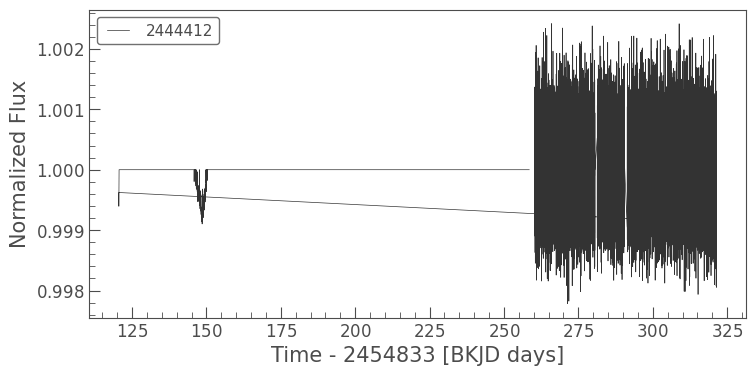

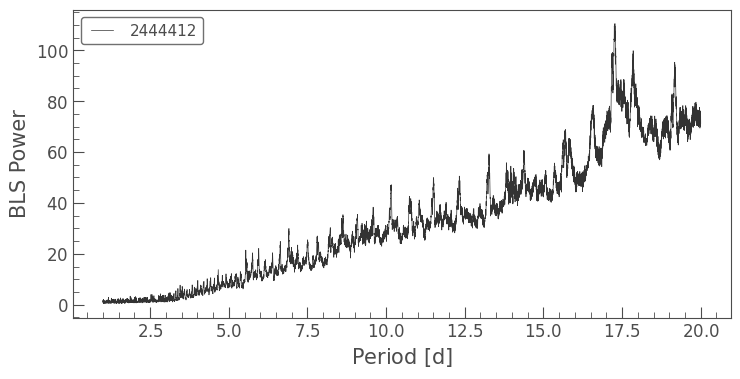

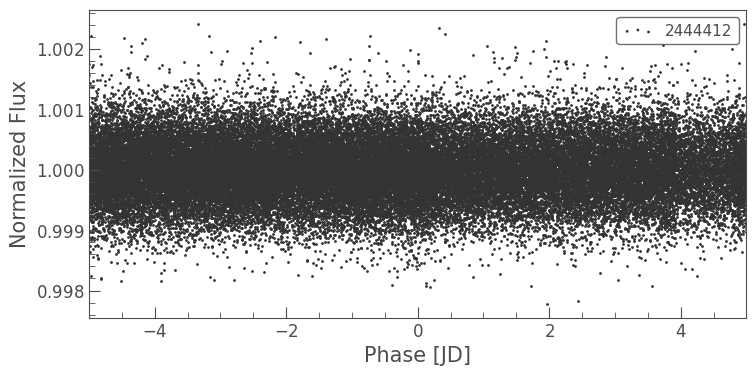

In [11]:
%matplotlib inline
import pandas as pd
import lightkurve as lk
import os
import concurrent.futures
import warnings
from threading import Lock
from astropy.utils.exceptions import AstropyWarning
import numpy as np

kepid = 2444412
lc = lk.read("lightcurves_fits/KIC" + str(kepid) + ".fits").flatten().remove_outliers()
# print(lc.flux)
lc.plot()




period = np.linspace(1, 20, 10000)
# Create a BLSPeriodogram
bls = lc.to_periodogram(method='bls', period=period, frequency_factor=500)
bls.plot()

planet_b_period = bls.period_at_max_power
planet_b_t0 = bls.transit_time_at_max_power
planet_b_dur = bls.duration_at_max_power

ax = lc.fold(period=planet_b_period, epoch_time=planet_b_t0).scatter()
radius = 5
ax.set_xlim(-radius, radius)

print(len(lc.flux))